# DeepESDL Use Case Planetary Health Index

This notebook is a technological summary on the computations used for the scientific Use Case 1 of the DeepESDL project. The goal of the use case is to detect syndromes of change by analyzing both earth observation data from biosphere and atmosphere together with a list of indicators describing socioeconomic development of certain regions. Previous work by Kraemer et al (http://dx.doi.org/10.5194/bg-17-2397-2020) used dimensionality reduction methods to summarize multivariate data cubes in indices so that trajectories atmosphere and biosphere could be summarized. 

While past work focused on building independent indices for the subsystems of the earth System (atmosphere, biosphere and anthroposphere), we want to focus on the interaction between different spheres in this study. We use the CCA (Canonical Correlation Analysis) method to construct indices with maximum capacity to predict data across domains, extracting information on how the spheres of the Earth System interact. In this notebook we show a condensed conceptual summary of the analysis. The code of the full study will be published on github (https://github.com/WantongLi111/Syndrome-of-change) as soon as the manuscript *Li, W. et al. Diagnosing syndromes of biosphere-atmosphere-socioeconomic change* which is currently under revision is accepted.

-----------------

**This notebook runs with the python environment `users-science-case-phi`, please checkout the documentation for [help on changing the environment](https://earthsystemdatalab.net/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kernel).**

In [1]:
import xarray as xr
from flox.xarray import xarray_reduce
from xcube.core.store import new_data_store
import numpy as np
import matplotlib.pyplot as plt

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<font size="+0.5">In order to work with the cluster service, the Dask processing cluster has to be added to your team from the <a href="https://portfolio.nor-discover.org/Service/Brockmann-DeepESDL/SponsoringWizardPricelist">NoR (Network of Resources) portal</a>. The example notebook will only run if your team has already access to the service and a suitable environment is selected.</font>
</div>

### You can still execute this notebook without using dask cluster service. It will just take a bit longer. To use dask cluster, please remove the comments from the cells needed for configuring the cluster. 

In [2]:
#import coiled

In [3]:
from xcube.util.dask import new_cluster
from dask.distributed import Client
import os

In [4]:
#del os.environ['JUPYTER_IMAGE']

In [5]:
#cluster = new_cluster(name='PHI', n_workers=20)


╭─────────────────────────────── Coiled Cluster ───────────────────────────────╮
│                   ]8;id=288619;https://cloud.coiled.io/clusters/1144623\https://cloud.coiled.io/clusters/1144623]8;;\                   │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────── Overview ──────────────╮╭─────────── Configuration ────────────╮
│                                      ││                                      │
│ Name: PHI                            ││ Region: eu-central-1                 │
│                                      ││                                      │
│ Scheduler Status: started            ││ Scheduler: m6i.xlarge                │
│                                      ││                                      │
│ Dashboard:                           ││ Workers:   m5.xlarge (20)            │
│ ]8;id=127752;https://cluster-jcatv.dask.host?token=i_G7plAO4NAV-2MM\https://cluster-jcatv.dask.host?toke]8;;\ ││                                      │
│ ]8;id=127752;https://cluster-jcatv.dask.host?token=i_G7plAO4NAV-2MM\n=i_G7plAO4NAV-2MM]8;;\                   ││ Workers Requested: 20                │
│                                      ││                                      │
╰──────────────────────────────────────╯╰──────────────────────────────────────╯
╭───────────────────────── (2025/09/11 13:28:15 UTC) ──────────────────────────╮
│                                                                              │
│          Most of your workers have arrived. Cluster ready for use.           │
│                                                                              │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯

In [6]:
#client = Client(cluster)

## Step 1 Aggregating the ESDC Data Cube to annual country resolution

When trying to co-interpret socioeconomic data with earth observation, the first problem to solve is the mismatch in spatial and temporal resolution at which these datasets usually are published. World bank data is available at annual time steps and for administrative regions while EO data comes in gridded formats. As a first step we aggregate the esdc data cube to country levels to match the socioeconomic data in resolution. 

We first open the esdc from the xcube store:

In [7]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

In [10]:
store = new_data_store("s3",
                       max_depth=3,
                       root="deep-esdl-public",
                       storage_options=dict(
                           anon=False, key=S3_USER_STORAGE_KEY, secret=S3_USER_STORAGE_SECRET)
                      )                      
ds = store.open_data('esdc-8d-0.25deg-1x720x1440-3.0.1.zarr')

And select the requested time period

In [11]:
store.list_data_ids()

['LC-1x2025x2025-2.0.0.levels',
 'LC-1x2160x2160-1.0.0.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-OS-20230101-20231231-1W-res0.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0.zarr',
 'SMOS-freezethaw-1x720x720-1.0.1.zarr',
 'SMOS-freezethaw-4267x10x10-1.0.1.zarr',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'SeasFireCube-8D-0.25deg-966x180x360-3.0.0.zarr',
 'SeasFireCube_v3.zarr',
 'black-sea-1x1024x1024.levels',
 'black-sea-256x128x128.zarr',
 'cmems_sst_v2.zarr',
 'esa-cci-permafrost-1x1151x1641-0.0.2.levels',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esdc-8d-0.083deg-184x270x270-2.1.1.zarr',
 'esdc-8d-0.25deg-1x720x1440-3.0.1.zarr',
 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr',
 'extrAIM-merged-cube-1x86x179.zarr',
 'hydrology-1D-0.009deg-100x60x60-3.0.2.zarr',
 

In [12]:
ds = ds.sel(time=slice("2003-01-01","2021-12-31"))

We select a subset of variables describing the state of both atmosphere and biosphere:

In [13]:
atm_var = ['air_temperature_2m', 'precipitation_era5','max_air_temperature_2m','min_air_temperature_2m',
       'potential_evaporation','radiation_era5',]
atm_svar = ['tair','prec','maxtair','mintair','pet','rad']

bio_var = ['evaporation',
           'gross_primary_productivity', 'kndvi',
           'root_moisture', 'sif_gosif', 'sm',
           'terrestrial_ecosystem_respiration']
bio_svar = ['evap','gpp','kndvi','rm','sif','sm','ter']

In order to aggregate these datasets on a country-level we load a country mask that encodes the worlds countries for every pixel as their UN numeric code

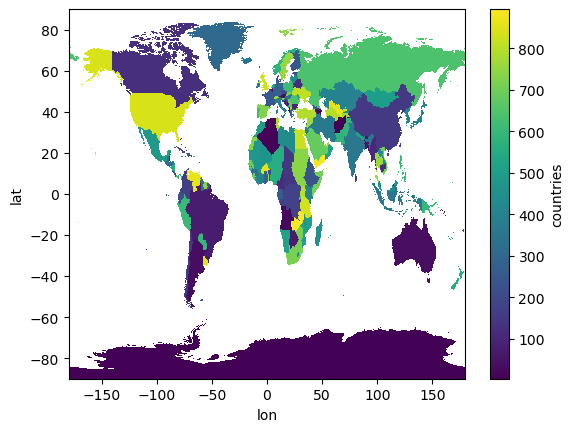

In [14]:
countries = store.open_data("science-cases/PHI-data/countries.nc")
countries.countries.plot()

Here we define a function that uses the [flox](https://flox.readthedocs.io/en/latest/) library for fast dask-based aggregations of large arrays to aggregate the esdc to annual and country-level resolution. Note that for demonstration purposes this is currently not doing area and population density weighting as in *Li W. et al* mentioned above.

In [15]:
def aggregate_countries(dataset, countrymask):
    reduced_dataset = xarray_reduce(dataset,countrymask,func="nanmean").resample(time="YE").mean(skipna=True).compute()
    
    #Set new coordinates according to ISO3 country codes instead of UN
    un2iso3 = {countries.attrs['UN'][i]: countries.attrs['ISO3'][i] for i in range(len(countries.attrs['ISO3']))}
    newcoords = {
        'countries': [un2iso3[k] for k in reduced_dataset.coords['countries'].values],
        'time' : np.arange(2003,2022)
    }
    return reduced_dataset.assign_coords(newcoords)

And we apply the reduction to the atmospheric and biospheric subset of the esdc:
**Note, if you don't use a dask cluster, then the process takes around 5min. With dask cluster on coiled it takes around 30s.**

In [16]:
%%time
atm_countrycube = aggregate_countries(ds[atm_var],countries.countries)

CPU times: user 800 ms, sys: 287 ms, total: 1.09 s
Wall time: 32 s


In [17]:
%%time
bio_countrycube = aggregate_countries(ds[bio_var],countries.countries)

/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 596 ms, sys: 29.2 ms, total: 626 ms
Wall time: 23.7 s


----------------------
### Shut down Dask cluster

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<font size="+0.5">
Once you are finished with your computations, make sure to shutdown the cluster so your quoata of  available CPU hours is not used for an idle cluster.</font>
</div>

In [18]:
cluster.shutdown()

The resulting datacube has only 2 axes: countries and time.

In [19]:
bio_countrycube

<xarray.Dataset> Size: 113kB
Dimensions:                            (time: 19, countries: 207)
Coordinates:
  * countries                          (countries) <U3 2kB 'AFG' 'ALB' ... 'ZMB'
  * time                               (time) int64 152B 2003 2004 ... 2020 2021
Data variables:
    evaporation                        (time, countries) float32 16kB 0.5016 ...
    gross_primary_productivity         (time, countries) float32 16kB 0.92 .....
    kndvi                              (time, countries) float32 16kB 0.02109...
    root_moisture                      (time, countries) float32 16kB 0.1732 ...
    sif_gosif                          (time, countries) float32 16kB -0.0039...
    sm                                 (time, countries) float32 16kB 0.1637 ...
    terrestrial_ecosystem_respiration  (time, countries) float32 16kB 0.8211 ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

We can produce a plot of the mean kndvi Germany and Italy

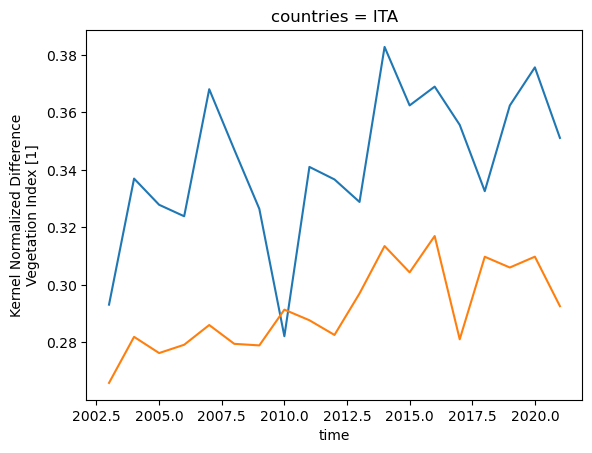

In [20]:
bio_countrycube.sel(countries='DEU')['kndvi'].plot()
bio_countrycube.sel(countries='ITA')['kndvi'].plot()

As the last step of the data preprocessing we normalize the data to zero mean and unit variance and store the result to netcdf files. 

In [21]:
team_store = new_data_store("s3",
                       root=S3_USER_STORAGE_BUCKET,
                       storage_options=dict(
                           anon=False, key=S3_USER_STORAGE_KEY, secret=S3_USER_STORAGE_SECRET
                       )
                      )


In [23]:
#Detrend and unit variance
def detrend(x):
    return (x-x.mean(dim='time'))/x.std(dim='time')
team_store.write_data(detrend(atm_countrycube), 'countrycube_atm.nc')
team_store.write_data(detrend(bio_countrycube), 'countrycube_bio.nc')

/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/conda/users/54b58749-1757596605-112-science-case-phi/lib/pytho

'countrycube_bio.nc'

In [24]:
team_store.list_data_ids()

['countrycube_atm.nc',
 'countrycube_bio.nc',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.rechunked.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v1.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v2.zarr',
 'SST.levels',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'analysed_sst_2.zarr',
 'analysed_sst_3.zarr',
 'analysed_sst_4.zarr',
 'cmems_sst_v1.zarr',
 'cmems_sst_v2.zarr',
 'esa-cci-permafrost-1x1151x1641-0.1.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.4.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.5.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.6.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.7.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.8.0.zarr',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esa_gda-health_pakistan_ERA5_precipitation_and_temperature_testdata.zarr',
 'noise_trajectory.zarr',
 's2_ndvi_lower_saxony_10D.zarr']

## Step 2 Computing MCCA together with socioeconnomic indices

In this part of the notebook the actual analysis. As a first step we merge the aggregated esdc data cubes together with the WDI inidcators into a single large dataframe by matching the ISO3 country name indicators.

In [25]:
from sklearn.cross_decomposition import CCA
import pandas as pd
import numpy as np
import xarray as xr

In [26]:
atm_countrycube = team_store.open_data('countrycube_atm.nc')
bio_countrycube = team_store.open_data('countrycube_bio.nc')
wdi_data = pd.read_csv('~/.shared/deepesdl/notebooks/science-cases/PHI/WDI_2003_2022_gapfilled_mask0.7.csv',index_col=('Country Code','year'))

In [27]:
wdi_data

,,EG.CFT.ACCS.ZS,EG.CFT.ACCS.RU.ZS,EG.CFT.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,SE.PRM.TENR,SE.PRM.TENR.FE,SE.PRM.TENR.MA,NY.ADJ.NNTY.KD.ZG,...,VA.STD.ERR,SL.EMP.VULN.FE.ZS,SL.EMP.VULN.MA.ZS,SL.EMP.VULN.ZS,SL.EMP.WORK.FE.ZS,SL.EMP.WORK.MA.ZS,SL.EMP.WORK.ZS,ER.GDP.FWTL.M3.KD,SG.LAW.INDX,SH.DYN.AIDS.FE.ZS
Country Code,year,,,,,,,,,,,,,,,,,,,,,
AFG,2003,-1.370957,-1.253621,-0.831503,-2.045394,-2.032765,-0.642633,-1.515060,-2.311958,-0.795809,-0.014570,...,1.673806,1.739524,2.098219,1.859170,-1.704699,-2.021793,-1.802788,-0.435048,-2.384321,-0.635867
ALB,2003,-0.437147,-0.714350,0.019330,0.677375,0.738880,0.388047,0.058993,0.337843,0.223829,0.076049,...,0.600778,0.503721,0.761108,0.640699,-0.482775,-0.832274,-0.665146,-0.406864,0.370755,-0.856260
DZA,2003,0.877862,0.941143,0.755413,0.651290,0.665681,0.522615,0.292921,0.412111,0.589842,0.204813,...,0.321565,-0.311775,-0.353906,-0.367896,0.315413,0.271737,0.282586,-0.315912,-1.611556,0.294681
AGO,2003,-0.565066,-1.128812,0.173264,-1.761520,-2.029211,-2.157139,-2.259912,-2.215257,-1.655678,0.236478,...,0.321565,1.016544,0.301361,0.732627,-1.050525,-0.364562,-0.778436,-0.073212,-0.435609,1.506842
ATG,2003,0.931588,1.056533,0.758211,0.626143,0.652954,0.554588,0.157915,0.082327,0.034531,0.394843,...,3.347341,-0.759417,-0.598588,-0.666694,0.777225,0.615010,0.684710,1.146915,-0.234018,0.431255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,2022,0.014173,-0.010199,0.076418,0.681262,0.731855,0.829491,1.496409,1.244598,1.304254,-0.068350,...,-0.529469,0.349534,0.414757,0.428930,-0.364406,-0.442677,-0.444494,-0.545674,0.941929,-0.436254
PSE,2022,0.506919,0.201387,0.756930,1.039188,0.992664,0.991992,0.057431,0.052956,-0.029367,-0.297910,...,0.363201,-0.676908,-0.801595,-0.776491,0.682158,0.756525,0.721833,-0.497033,-2.384321,-0.511382
YEM,2022,-0.565611,-0.540403,-0.418008,-0.341460,-0.340948,-0.317355,-1.403651,-1.567666,-1.410420,-0.063294,...,-0.274073,0.488380,0.414499,0.390357,-0.469442,-0.427279,-0.416500,-0.379340,-2.350722,-0.006176


In [28]:
#Identify country codes present both in countrycubes and in WDI
countries_overlap = np.intersect1d(np.array([i[0] for i in wdi_data.index]),atm_countrycube.countries.values)

In [29]:
wdi_df = wdi_data.loc[countries_overlap].query("year < 2022").dropna(axis=1)
atm_df = atm_countrycube.to_dataframe().loc[countries_overlap]
bio_df = bio_countrycube.to_dataframe().loc[countries_overlap]

In [30]:
alldata = pd.concat((wdi_df,atm_df,bio_df),axis=1).dropna()
alldata

EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
AFG 2003       -1.370957          -1.253621          -0.831503   
    2004       -1.342815          -1.244202          -0.713954   
    2005       -1.306998          -1.234782          -0.593606   
    2006       -1.271180          -1.220653          -0.481654   
    2007       -1.235363          -1.208878          -0.372501   
...                  ...                ...                ...   
ZWE 2016       -0.859280          -1.157071           0.178861   
    2017       -0.864397          -1.154716           0.170465   
    2018       -0.859280          -1.150006           0.164867   
    2019       -0.854164          -1.142941           0.153672   
    2020       -0.851605          -1.140586           0.153672   

          EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  SE.PRM.TENR  \
AFG 2003       -2.045394          -2.032765          -0.642633    -1.515060   
    2004       -1.881414          -1.870992          -0.570373    -1.981845   
    2005       -1.717011          -1.658229          -0.827528    -1.996191   
    2006       -1.551955          -1.547522          -0.422510    -1.541559   
    2007       -1.386195          -1.384073          -0.346540    -1.842168   
...                  ...                ...                ...          ...   
ZWE 2016       -1.249892          -1.471589          -0.215809    -0.000649   
    2017       -1.198647          -1.406508          -0.216847     0.104978   
    2018       -1.150525          -1.346046          -0.218329     0.144295   
    2019       -1.107124          -1.292074          -0.220105    -0.026285   
    2020       -0.901749          -1.043560          -0.203360     0.112703   

          SE.PRM.TENR.FE  SE.PRM.TENR.MA  NY.ADJ.NNTY.KD.ZG  ...  \
AFG 2003       -2.311958       -0.795809          -0.014570  ...   
    2004       -2.791516       -0.986661           0.167548  ...   
    2005       -2.527603       -1.158617           0.197484  ...   
    2006       -2.080228       -0.808782           0.077743  ...   
    2007       -2.338078       -1.073416           0.767670  ...   
...                  ...             ...                ...  ...   
ZWE 2016        0.002839       -0.034695          -0.131057  ...   
    2017        0.090151        0.019691           0.015720  ...   
    2018        0.121707        0.067325          -1.609957  ...   
    2019        0.128408       -0.144965           1.859286  ...   
    2020        0.385196       -0.018469          -0.682648  ...   

          min_air_temperature_2m  potential_evaporation  radiation_era5  \
AFG 2003               -1.475445              -0.626484       -0.188492   
    2004               -0.227529               0.477794        0.709786   
    2005               -1.135158              -0.928594       -0.839212   
    2006                0.851772               0.657814        0.016594   
    2007               -0.513012               0.394774        0.032246   
...                          ...                    ...             ...   
ZWE 2016                1.724522               1.130604        0.638819   
    2017               -0.490266              -1.181224       -1.575181   
    2018                0.653059               0.379604        0.372145   
    2019                1.346734               1.798219        1.772513   
    2020                1.723340              -1.302509       -1.293263   

          evaporation  gross_primary_productivity     kndvi  root_moisture  \
AFG 2003     0.019062                    0.315682  0.551539       0.047335   
    2004    -1.479052                   -1.586688 -0.653485      -0.972850   
    2005    -0.197261                   -0.007116  0.357319       0.648013   
    2006    -1.392693                   -1.127309 -1.137097      -0.929048   
    2007     0.034863                    0.124563  0.419393      -0.031020   
...               ...                         ...       ...            ...   
ZWE 

The table above is now a merged dataframe of worldbank socioeconomic indicators with data extracted from the esdc. We can use normal pandas data indexing rules to, for example we can extract a normalized annual time series of sif for the country of Italy:

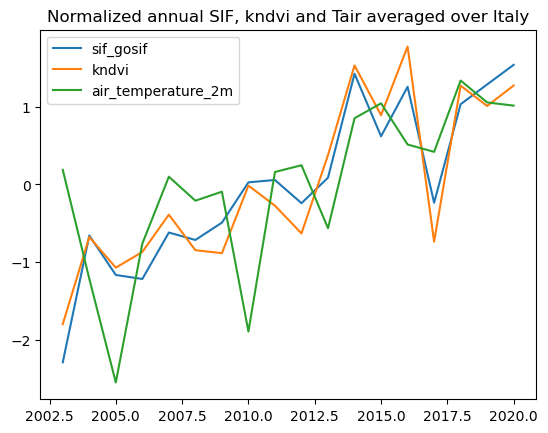

In [31]:
alldata[['sif_gosif','kndvi','air_temperature_2m']].loc['ITA'].plot()
plt.title("Normalized annual SIF, kndvi and Tair averaged over Italy")
plt.show()

As a next step we define a function that performs a Canonical Correlation analysis on different subsets of the dataset representing certain domains and therefore constructing principal components from the data that maximise the explained variance across the different domains. 

In [32]:
def cca_subgroups(alldata, ncomp=1, **names):
    n1,n2 = list(names.keys())
    subset1 = names[n1]
    subset2 = names[n2]
    model = CCA(ncomp).fit(alldata[subset1],alldata[subset2])
    tr1, tr2 = model.transform(alldata[subset1],alldata[subset2])
    transformed1 = pd.DataFrame(tr1,index = alldata.index,columns=['{}_Comp{}'.format(n1,i+1) for i in range(ncomp)])
    transformed2 = pd.DataFrame(tr2,index = alldata.index,columns=['{}_Comp{}'.format(n2,i+1) for i in range(ncomp)])
    return model,pd.concat([transformed1,transformed2],axis=1)

We first apply the CCA on subsets of atmosphere an biosphere variables

In [33]:
model, transformed = cca_subgroups(alldata,ncomp=2, atm=atm_var, bio=bio_var)

This results in a transformed dataframe where component 1 and 2 are computed both based on atmos[pheric and biospheric data:

In [34]:
transformed

atm_Comp1  atm_Comp2  bio_Comp1  bio_Comp2
AFG 2003   0.085622  -1.030812   0.157922  -0.292160
    2004   0.959350   0.034229   0.838714  -0.582942
    2005  -1.055503  -0.785706  -0.491882  -0.707531
    2006  -0.025981   0.857641   0.591726  -0.363832
    2007   0.036199   0.277627   0.151489   0.135674
...             ...        ...        ...        ...
ZWE 2016   0.713924   1.346705   1.139171  -0.025858
    2017  -2.443722  -0.521449  -2.007304   0.567911
    2018   0.643321   0.429425  -0.413124  -0.210140
    2019   2.370890   1.370719   1.196972  -0.475497
    2020  -1.426962   0.124987   0.570861   0.133499

[2876 rows x 4 columns]

As designed by the method, the components are highly correlated, which can be inspected by a scatter plot. 

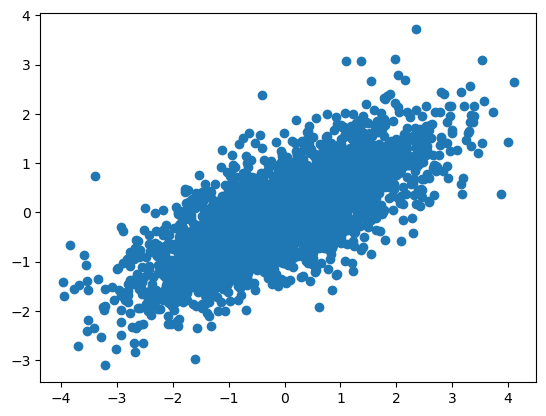

In [35]:
plt.scatter(transformed['atm_Comp1'],transformed['bio_Comp1'])

To get a better overview one can inspect trajectories for single countries in the CCA compnents space and start looking at outlier years. 

In [36]:
def country_scatterplot(transformed, country, comp=1):
    n1,n2 = [n for n in transformed if 'Comp{}'.format(comp) in n]
    components = transformed.loc[country]
    fig, ax = plt.subplots()
    ax.scatter(components[n1],components[n2])
    n1s, n2s = n1.split('_')[0],n2.split('_')[0]
    plt.xlabel(n1s)
    plt.ylabel(n2s)
    plt.title("{}-{} Trajectory".format(n1s,n2s))
    for y in range(2003,2021):
        ax.annotate(str(y),(components[n1][y],components[n2][y]))

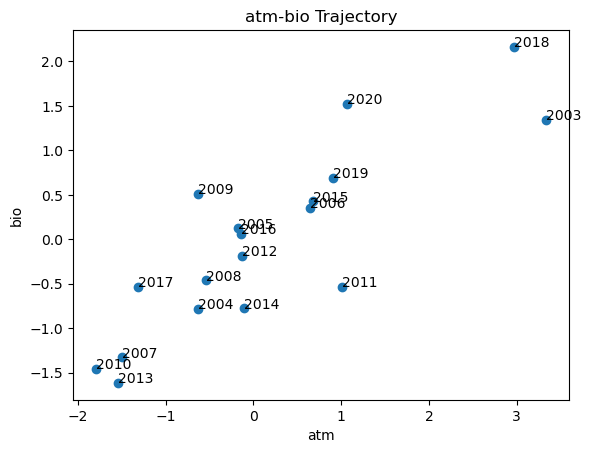

In [37]:
country_scatterplot(transformed,'DEU')

To improve interpretability we can have a look at the weights for the component construction. The Component 1 is high warm and dry anomalies during a year. 

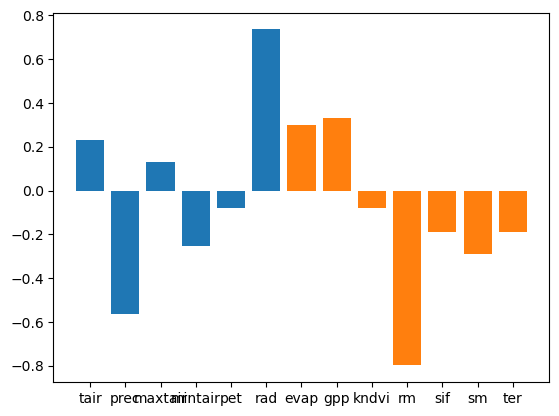

In [38]:
plt.bar(atm_svar,model.x_weights_[:,0])
plt.bar(bio_svar,model.y_weights_[:,0])
plt.show()

In the next step we repeat the CCA for the biosphere and socioeconomic subset of the data and can investigate the correlation structure of the extracted components:


In [39]:
wdi_var = wdi_df.columns.values

In [40]:
model, transformed = cca_subgroups(alldata,ncomp=2, bio=bio_var, soc=wdi_var)

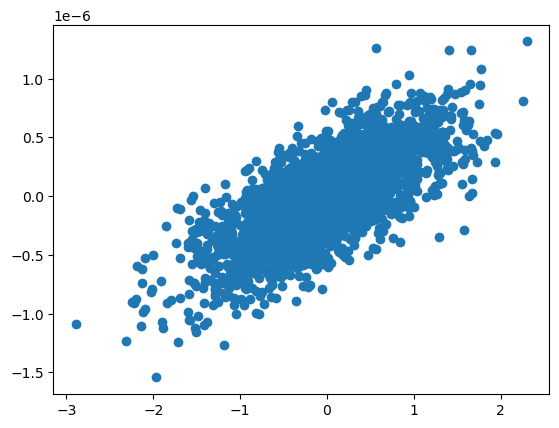

In [41]:
plt.scatter(transformed['bio_Comp1'],transformed['soc_Comp1'])
plt.show()

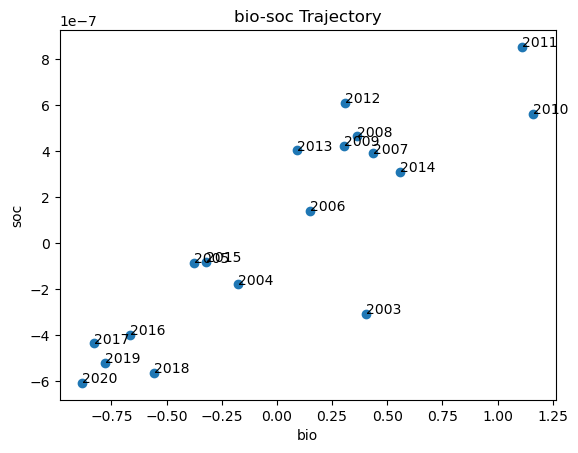

In [42]:
country_scatterplot(transformed,'DEU')

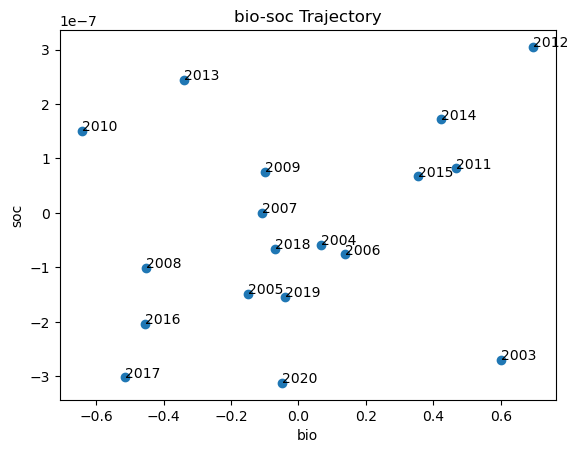

In [43]:
country_scatterplot(transformed,'ITA')

In [44]:
team_store.delete_data('countrycube_atm.nc')

In [45]:
team_store.delete_data('countrycube_bio.nc')